In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np
from scipy.sparse import csr_matrix


In [4]:
path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/soc-delicious/soc-delicious.mtx'

G = read_directed_graph(path,1)

In [5]:
with open('saved/network_metrics_deli.json', 'r') as f:
    loaded_data = json.load(f)

# 访问加载的数据
sorted_centrality = loaded_data["Centrality"]
#sorted_betweenness = loaded_data["Betweenness"]
#sorted_closeness = loaded_data["Closeness"]
sorted_pagerank =  loaded_data["PageRank"]
#sorted_leaderRank =  loaded_data["LeaderRank"]
sorted_hIndex =  loaded_data["HIndex"]
sorted_kShell=  loaded_data["KShell"]
# 更多的访问可以根据需要添加


In [6]:

print(sorted_hIndex[:3])
#print(loaded_betweenness)


[['133136', 126], ['116370', 122], ['115043', 119]]


In [8]:
def community_aware_ranking(partition, node_centrality, budget=10):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [9]:
degree_centrality = nx.degree_centrality(G)

In [15]:
# 示例：检测社区并统计前top节点的分布
G_edge = nx.read_edgelist('/Users/qing/Desktop/24s1/comp8880/project/code/data/soc-delicious/soc-delicious.mtx')
partition = partition = community_louvain.best_partition(G_edge)



In [16]:

budget = 100

ranked_nodes_Baseline = community_aware_ranking(partition, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_Baseline)


Ranked Nodes: ['706', '6888', '1919', '1047', '1177', '79237', '341823', '7573', '27124', '723', '4605', '1091', '2898', '23506', '158056', '14148', '3', '16210', '186230', '7602', '50698', '766', '15114', '38083', '294411', '68454', '324814', '50714', '8738', '33858', '182630', '1711', '1902', '1322', '5009', '39672', '90405', '6870', '40109', '25637', '80772', '58883', '2289', '35948', '87212', '355912', '102602', '29247', '19433', '339885', '111565', '95481', '77169', '667', '108045', '38908', '9484', '98882', '190955', '15006', '214528', '30783', '65224', '317595', '15342', '198323', '25130', '45023', '27176', '308494', '8447', '9763', '89014', '189222', '17172', '347912', '27350', '13369', '113741', '193966', '108394', '242810', '51371', '51437', '30650', '287927', '102536', '165124', '183883', '16918', '214080', '5910', '15227', '2579', '231873', '188575', '70562', '213979', '4076', '30752']


In [17]:


import numpy as np

def community_aware_ranking_ours_past(partition, leader_rank_scores, budget=10, alpha=2):
    # Organize nodes by community
    community_nodes = {}
    community_sizes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
            community_sizes[comm] = 0
        community_nodes[comm].append(node)
        community_sizes[comm] += 1

    # Calculate community weights based on size and LeaderRank scores
    community_weights = {}
    for comm, nodes in community_nodes.items():
        leader_rank_sum = sum(leader_rank_scores[node] for node in nodes)
        community_weights[comm] = (community_sizes[comm] * leader_rank_sum) ** alpha
    
    # Normalize weights to distribute budget
    total_weight = sum(community_weights.values())
    community_budgets = {comm: int(budget * (weight / total_weight)) for comm, weight in community_weights.items()}
    
    # Adjust budget rounding issues
    allocated_budget = sum(community_budgets.values())
    while allocated_budget < budget:
        for comm in community_budgets:
            community_budgets[comm] += 1
            allocated_budget += 1
            if allocated_budget == budget:
                break

    # Select nodes from communities based on assigned budgets
    ranked_nodes = []
    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: leader_rank_scores[x], reverse=True)
        ranked_nodes.extend(community_nodes[comm][:community_budgets[comm]])

    return ranked_nodes



def community_aware_ranking_ours_v4(partition, leader_rank_scores, community_kshell, budget=10, alpha=1.5):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: leader_rank_scores[x], reverse=True)

    # Calculate total k-shell values for each community to determine budget distribution
    community_kshell_sums = {}
    for node, comm in partition.items():
        if comm not in community_kshell_sums:
            community_kshell_sums[comm] = 0
        community_kshell_sums[comm] += community_kshell[node]

    # Calculate total k-shell values across all communities to normalize the distribution
    total_kshell_sum = sum(community_kshell_sums.values())

    # Determine budget for each community based on their k-shell sum raised to the power alpha
    community_budgets = {comm: int(((community_kshell_sums[comm] / total_kshell_sum) ** alpha) * budget) for comm in community_nodes}

    # Adjust budgets due to integer rounding, distribute any remaining budget
    allocated_budget = sum(community_budgets.values())
    while allocated_budget < budget:
        for comm in sorted(community_budgets, key=lambda x: community_kshell_sums[x], reverse=True):
            community_budgets[comm] += 1
            allocated_budget += 1
            if allocated_budget == budget:
                break

    # Select nodes from communities based on assigned budgets
    ranked_nodes = []
    for comm in sorted(community_nodes, key=lambda x: community_kshell_sums[x], reverse=True):
        ranked_nodes.extend(community_nodes[comm][:community_budgets[comm]])

    return ranked_nodes


In [18]:
import networkx as nx
import numpy as np
import community as community_louvain

def community_aware_ranking_ours_v5(G, partition, degree_centrality, k_shell_scores, total_budget, distance_threshold):
    """
    对社交网络进行资源分配和节点选择，结合社区划分、节点度中心性、k-shell得分和距离阈值。
    使用线性归一化来代替Softmax进行预算分配。

    参数:
    G: NetworkX图对象，表示社交网络。
    partition: 字典，节点到社区ID的映射。
    degree_centrality: 字典，节点的度中心性得分。
    k_shell_scores: 字典，节点的k-shell得分。
    total_budget: 整个网络的总预算，表示可以选择的节点总数。
    alpha: k-shell得分的权重。
    beta: 社区大小得分的权重。
    distance_threshold: 最短路径距离阈值，用于确定节点间的紧密程度。

    返回:
    selected_nodes: 被选择的节点集合。
    """

    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([k_shell_scores[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = size_score * (core_score)
    #print("Community Scores:", community_scores)

    # 使用线性归一化来分配预算
    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

   # print(community_budgets)
    # 选择节点，考虑节点间的距离阈值
    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []

        # 按度中心性排序
        nodes_sorted = sorted(community_nodes, key=lambda n: degree_centrality[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
                # 检查距离阈值
                too_close = any(nx.has_path(G, node, selected_node) and nx.shortest_path_length(G, node, selected_node) <= distance_threshold for selected_node in selected_for_comm)
                if not too_close:
                    selected_for_comm.append(node)
                    selected_nodes.add(node)
                    
    return selected_nodes

# 注意：使用该函数前需要提供有效的G, partition, degree_centrality, k_shell_scores等数据。


In [19]:
kShell = nx.core_number(G)

In [20]:
indegree_centrality = nx.in_degree_centrality(G)

In [26]:
hIndex = calculate_h_index(G)

In [23]:
leaderRank = leader_rank(G)

In [29]:
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)

In [24]:

total_budget = 200

#ranked_nodes_ours_infomap = community_aware_ranking_ours_v4(partition, leaderRank,kShell, budget)

ranked_nodes_ours = community_aware_ranking_ours_v4(partition, leaderRank,kShell, total_budget)


print("Ranked Nodes:", ranked_nodes_ours)


Ranked Nodes: ['706', '844', '768', '755', '136', '807', '823', '1120', '1596', '5642', '1703', '233', '1155', '94', '3969', '1372', '15473', '1368', '6809', '9478', '9284', '6888', '1367', '75', '1177', '1113', '1151', '1', '41', '78', '320', '978', '935', '3777', '16086', '7573', '6830', '2898', '537', '1091', '4605', '341823', '723', '2755', '710', '16210', '898', '3', '7602', '186230', '205808', '891', '112099', '2289', '93497', '354', '766', '923', '35948', '9', '33858', '40109', '50698', '324814', '50714', '60570', '8738', '1322', '6870', '5669', '38908', '227039', '80967', '183883', '1902', '13369', '80772', '95481', '1600', '90405', '5009', '15227', '77169', '9909', '5', '198323', '33952', '20', '94638', '15342', '58883', '30650', '30783', '1384', '195608', '25637', '3498', '89014', '94662', '51371', '17375', '65224', '29247', '308494', '2313', '339885', '17172', '2717', '205550', '108394', '189222', '95402', '51437', '47812', '95614', '30752', '102536', '178736', '8447', '1885

In [36]:
ranked_nodes_v5 = community_aware_ranking_ours_v5(G_edge, partition, leaderRank, hIndex, total_budget, distance_threshold=0)


2.5479213143620316


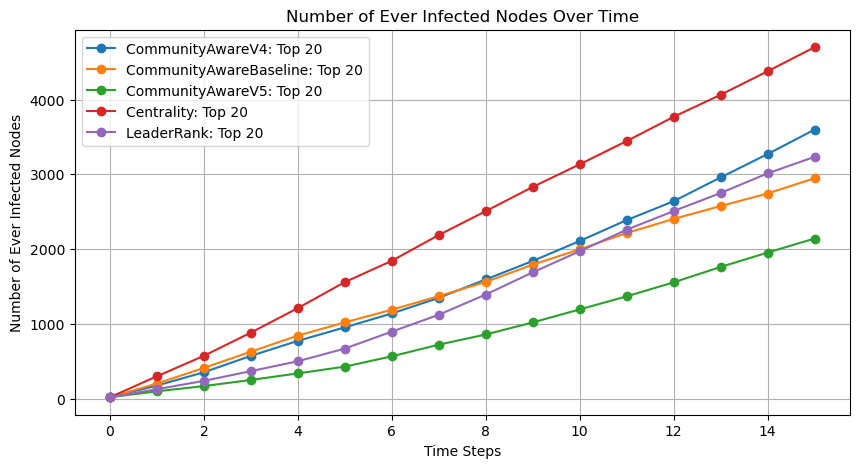

In [37]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
    print(avg_in_degree)
    recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 0.1, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    "CommunityAwareV4": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
   # "CommunityAwareOursInfomMap": [(node, degree_centrality[node]) for node in ranked_nodes_ours_infomap],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_Baseline],
    "CommunityAwareV5": [(node, degree_centrality[node]) for node in ranked_nodes_v5],
    "Centrality": sorted_centrality,
    #"PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    #"H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=20, infection_prob=0.008,steps=15)

In [14]:
def read_directed_graph(file_path, skip_lines):
    G = nx.DiGraph()  # Initialize an empty directed graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only consider lines with exactly two node identifiers
                u, v = parts
                G.add_edge(u, v)
    
    return G


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores





def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [ ]:
# Initialize an empty directed graph

# Load the .mtx file
path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/soc-delicious/soc-delicious.mtx'

G = read_directed_graph(path,1)
# Calculate number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

centrality = nx.degree_centrality(G)
#betweenness_manual = nx.betweenness_centrality(G)
#closeness_manual = nx.closeness_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
#leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)

sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
#sorted_betweenness = sorted(betweenness_manual.items(), key=lambda item: item[1], reverse=True)
#sorted_closeness = sorted(closeness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
#sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)

data_to_save = {
    "Centrality": sorted_centrality,
    #"Betweenness": sorted_betweenness,
    #"Closeness": sorted_closeness,
    "PageRank": sorted_pagerank,
    #"LeaderRank": sorted_leaderRank,
    "HIndex": sorted_hIndex,
    "KShell": sorted_kShell
}

with open('saved/network_metrics_deli.json', 'w') as f:
    json.dump(data_to_save, f, indent=4)